<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/6_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCN

- wavenet에 사용된 TCN(Temporal Convolutional Networks)을 사용하였습니다.
    - 결과: 19.66194 (최대)(submission_TCN_200414_1.csv)
    - 결과: 19.73639 (현재)(submission_TCN_2.csv)
- [TCN 논문](https://arxiv.org/abs/1611.05267)
- [TCN 설명 포스트](http://www.secmem.org/blog/2019/08/18/wavenet/)

- LSTM보다 성능이 좋았으며, 후에 GB based model과 ensemble 했을 때 효과가 있었습니다.
- 계절성(seasonality)를 dilation을 이용해 반영하였습니다.
- dilation의 마지막 1은 전달(previous month)뿐만 아니라 그 양옆까지 학습시키기 위함입니다.

In [ ]:
import pandas as pd
import numpy as np
import glob, re, gc, os
np.random.seed(777)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, LSTM,  Flatten, Dropout, BatchNormalization,
    Reshape, Lambda, add, concatenate, Conv1D, SpatialDropout1D,
    GRU, RNN, Input
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    prev_x = x
    for _ in range(2):
        x = Conv1D(filters = nb_filters,
                   kernel_size = kernel_size,
                   dilation_rate = dilation_rate,
                   padding = padding,
                   activation = 'relu')(x)
        x = BatchNormalization()(x) # batchnormalization 빼야함 안그러면 그래디언트 폭주 현상 발생
        if dropout_rate != 0:
            x = SpatialDropout1D(rate = dropout_rate)(x)
            
    prev_x = Conv1D(filters = nb_filters, 
                    kernel_size = 1, 
                    padding = 'same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x

class TCN:
    def __init__(self,
                 nb_filters = 64,
                 kernel_size = 2,
                 nb_stacks = 1,
                 dilations = [1, 2, 4, 8, 16, 32],
                 padding = 'causal',
                 use_skip_connections = True,
                 dropout_rate = 0.0,
                 return_sequences = False,
                 name = 'tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.padding = padding
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

    def __call__(self, inputs):
        x = inputs
        x = Conv1D(filters = self.nb_filters, 
                   kernel_size = 1, 
                   padding = self.padding)(x)
        skip_connections = []
        for _ in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x,
                                             dilation_rate = d,
                                             nb_filters = self.nb_filters,
                                             kernel_size = self.kernel_size,
                                             padding = self.padding,
                                             dropout_rate = self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = add(skip_connections)
        if not self.return_sequences:
            x = Lambda(lambda t: t[:, -1, :])(x)
        return x

In [ ]:
train = pd.read_csv('data/train_clean.csv', index_col = 'id')
test = pd.read_csv('data/test.csv', index_col = 'id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(train.shape, test.shape, sample_submission.shape) 

(61651, 125) (10000, 113) (10000, 12)


- submission_TCN_200414_1.csv
    - 2009년 6월부터 2018년 5월까지 데이터 사용
    - nb_filters = 128, dilations = [12, 24, 1]
- submission_TCN_2.csv
    - 2011년 6월부터 2018년 5월까지 데이터 사용
    - nb_filters = 64, dilations = [12, 24, 36, 1]

In [ ]:
X = train.loc[:, '2011-06': '2018-05']
y = train.loc[:, '2018-06':]
X_test = test.loc[:, '2011-06':]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [ ]:
def build_model(input_shape):
    inputs = Input(shape = (input_shape, ))
    x = Reshape((1, input_shape))(inputs)
    x = TCN(nb_filters = 64, kernel_size = 2, nb_stacks = 2, dilations = [12, 24, 36, 1], dropout_rate = 0.2)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(12, activation = 'linear')(x)

    adam = Adam(lr=0.0005)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss = 'mse', optimizer = adam)
    return model

In [ ]:
model = build_model(X_train.shape[1])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 84)           0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 84)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1, 64)        5440        reshape[0][0]                    
________________________________________________________________________

Train on 49308 samples, validate on 12328 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 40s - loss: 2675.9795 - val_loss: 931.8286
Epoch 2/100
 - 26s - loss: 1085.7092 - val_loss: 1020.3303
Epoch 3/100
 - 25s - loss: 981.1628 - val_loss: 818.5390
Epoch 4/100
 - 26s - loss: 927.4394 - val_loss: 896.6527
Epoch 5/100
 - 26s - loss: 888.2757 - val_loss: 818.1472
Epoch 6/100
 - 26s - loss: 861.8547 - val_loss: 728.6470
Epoch 7/100
 - 26s - loss: 849.6897 - val_loss: 771.2231
Epoch 8/100
 - 26s - loss: 834.5887 - val_loss: 702.1884
Epoch 9/100
 - 25s - loss: 827.7358 - val_loss: 702.2929
Epoch 10/100
 - 26s - loss: 815.3831 - val_loss: 706.8614
Epoch 11/100
 - 25s - loss: 806.2463 - val_loss: 706.2641
Epoch 12/100
 - 26s - loss: 805.4038 - val_loss: 684.2012
Epoch 13/100
 - 26s - loss: 795.9284 - val_loss: 686.3892
Epoch 14/100
 - 25s - loss: 796.4930 - val_loss: 689.5672
Epoch 15/100
 - 25s - loss: 792.1880 - val_loss: 712.7927
Epoch 16/100
 - 25s - loss: 794.1858 -

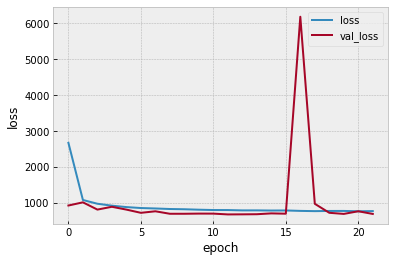

In [ ]:
# TCN 학습시작
# 모델이 저장될 models 폴더가 있어야 작동을 합니다.
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 5, patience = 10)
model_checkpoint = ModelCheckpoint('models/TCN_model_2.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist_model = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 256,
    verbose = 2, 
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping, model_checkpoint]
)

plt.plot(hist_model.history['loss'], label = 'loss')
plt.plot(hist_model.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model = load_model('models/TCN_model_2.h5')

In [ ]:
y_pred = model.predict(X_valid)
y_true = y_valid.values

In [ ]:
np.mean(np.sqrt(np.mean(np.square(y_true - y_pred), axis = 0)))

23.28545038356771

In [ ]:
model = load_model('models/TCN_model_200414_1.h5')
pred = pd.DataFrame(
    data = model.predict(train.loc[:, '2009-06': '2018-05']),
    columns = sample_submission.columns,
    index = train.index
)

In [ ]:
X_sample, y_sample = train.iloc[3, :-12], train.iloc[3, -12:]
y_pred = pred.iloc[3]

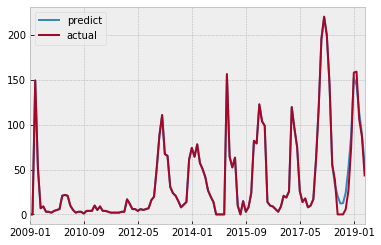

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
pred = model.predict(X_test.values)
sample_submission = pd.DataFrame(data = pred, columns = sample_submission.columns, index = sample_submission.index)
sample_submission.to_csv('submissions/submission_TCN_2.csv')